## Introduction to models

L1 regularized logistic regression solves the following optimization problem:

Logistic regression belongs to the family of classifiers known as the exponential or log-linear classifiers. It works by extracting some set of weighted features from the input, taking logs, and combining them linearly (meaning that each feature is multiplied by a weight and then added up). Technically, logistic regression refers to a classifier that classifies an observation into one of two classes, and multinomial logistic regression is used when classifying into more than two classes, although informally we sometimes use the shorthand logistic regression even when we are talking about multiple classes.

If a feature is perfectly predictive of the outcome because it happens to only occur in one class, it will be assigned a very high weight. The weights for features will attempt to perfectly fit details of the training set, in fact too perfectly, modeling noisy factors that just accidentally correlate with the class. This problem is called **overfitting**.

Therefore, there are two common regularization terms called **L1** and **L2** to avoid overfitting:

**L1** regularization is a linear function of the weight values, named after the L1 norm |w|, the sum of the absolute values of the weights. <br>
**L2** regularization is called ridge regression which is sum of the square of the weights ||w||.

#### The LogisticRegression in sklearn

Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a [logistic function](https://en.wikipedia.org/wiki/Logistic_function).

To opimize the problem, we need to minimize the 

$$
f(x) = \frac 1 {1+e^{-x}}
$$

L1 regularized logistic regression solves the following optimization problem:
$$
min\frac1{2}w^Tw + C \sum_{i = 1}^n log(exp(-y_{i}(X_{i}^Tw + c)) + 1)
$$

L2 penalized logistic regression minimizes the following cost function:

$$
min\frac1{2}||w||_{1} + C \sum_{i = 1}^n log(exp(-y_{i}(X_{i}^Tw + c)) + 1)
$$

Reference : https://web.stanford.edu/~jurafsky/slp3/7.pdf

## Building model

In [77]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [78]:
data = pd.read_csv('final_df_sample_2.csv', index_col = 0)

In [79]:
# Get the features and class
feature_names = data.columns[1:-2]
class_name = data.columns[-1]

In [80]:
X = np.array(data[feature_names])
y = np.array(data['label_model'])

In [81]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [82]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize = True.
    Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.figure(dpi = 100)
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float")/cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Tuning parameters for Logistic Classification

In [83]:
C_range = np.logspace(-3, 3, 7)  # Ridge penalty parameter.
cv = KFold(n_splits = 5, random_state = 9) # 5-fold cross validation.
class_weight = [{'Fake': 3}]
parameters = dict(penalty = ("l1", "l2"), C = C_range, class_weight = class_weight)
find_best_est = GridSearchCV(LogisticRegression(), param_grid = parameters, cv = cv, n_jobs = 4)
find_best_est.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" % (find_best_est.best_params_, 
                                                                find_best_est.best_score_))


The best parameters are {'penalty': 'l1', 'C': 100.0, 'class_weight': {'Fake': 3}} with a score of 0.96


In [84]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [85]:
report(find_best_est.cv_results_)

Model with rank: 1
Mean validation score: 0.960 (std: 0.003)
Parameters: {'penalty': 'l1', 'C': 100.0, 'class_weight': {'Fake': 3}}

Model with rank: 2
Mean validation score: 0.959 (std: 0.004)
Parameters: {'penalty': 'l1', 'C': 1000.0, 'class_weight': {'Fake': 3}}

Model with rank: 3
Mean validation score: 0.959 (std: 0.004)
Parameters: {'penalty': 'l1', 'C': 1.0, 'class_weight': {'Fake': 3}}



In [86]:
log_pred = find_best_est.predict(X_test)
print 'the accuracy of logistic is {}'.format(accuracy_score(y_test, log_pred))

the accuracy of logistic is 0.970769230769


Normalized confusion matrix


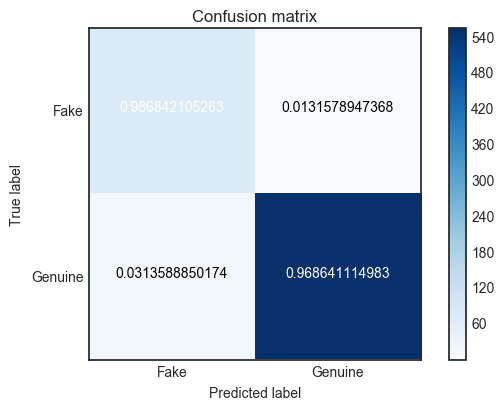

In [87]:
with plt.style.context(("seaborn-white")):
    conf_matrix = confusion_matrix(y_test, log_pred)
    plot_confusion_matrix(conf_matrix, classes = ['Fake', 'Genuine'], normalize = True)
    plt.savefig('Confusion_df_2.png', bbox_inches='tight')

As we observe above, although the accuracy of identifying account by using Logistic Classification is around 90.92%, the ratio of identifying fake account given true label is only around 35.52%. This is because the accuracy of genuine given the true lbel improve the overall accuracy. The goal of this project is to identify the fake account accurately, even if the overall accuracy would relatively decrease a little bit.

Then we start to tune the parameters for logistic classification model by using GridSearchCV in Scikit-learn library to ﬁnd the best parameters. The main parameters to tune are C, penalty and the class_weight. The C is inverse of regularization strength which is parameter of the penalty. Also, the settings of the penalty here are L1 and L2. The most important thing we need to adjust is the class weight for the fake to penalize the error to identifying fake account.

After getting the new parameters and fitting the new model, we gain the higher accuracy of identify accounts which is 95.38%. Moreover, the the ratio of predicting fake account correctly is about the 88.16%.

\begin{table}[h!]
 \captionof{table}{Best Parameters of Logistic Regression} \label{tab:title} 
 \begin{center}
  \begin{tabular}{rrrrrr}
   \hline
   & Cost & Penalty & Class weight & Mean validation score & Accuracy score\\
   \hline
   Sample 1 & 1.0 & l1 & 3 & 0.964 & 0.962\\
   Sample 2 & 100 & l1 & 3 & 0.960 & 0.971\\
   Sample 3 & 10  & l1 & 3 & 0.970 & 0.965\\
   \hline
  \end{tabular}
 \end{center}
\end{table}